In [1]:
import pennylane as qml
from pennylane import numpy as np
import torch
from torch.optim import Adam
from torch.nn.parameter import Parameter
from torch.nn import NLLLoss
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import torchvision
from torch.nn import Module
import torch.nn.functional as F
from torch.nn import Conv2d, Dropout2d, Linear
from torch import cat
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
from datetime import datetime
import pprint

d:\miniconda3\Lib\site-packages\pennylane\__init__.py:196: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.0 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,))
        ])

train_ds = torchvision.datasets.FashionMNIST(
    "./", train=True, download=True,
    transform=transform)

test_ds = torchvision.datasets.FashionMNIST(
    "./", train=False, download=True,
    transform=transform)


train_mask = (train_ds.targets == 0) | (train_ds.targets == 6)
train_idx = torch.where(train_mask)[0]
train_ds.targets[train_ds.targets == 6] = 1

binary_train_ds = Subset(train_ds, train_idx)
train_loader = DataLoader(binary_train_ds, batch_size = 1, shuffle =True)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

In [3]:
torch.set_default_dtype(torch.float64)
class BinaryClassifier(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 4, kernel_size=5)
        self.conv2 = Conv2d(4, 32, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(32 * 4 * 4, 64)
        self.fc2 = Linear(64, 2)
        self.fc3 = Linear(1, 1)

        # Quantum layer
        self.q_device = qml.device("default.qubit", wires=2)
        self.qnn_params = Parameter(torch.rand(8), requires_grad= True)
        self.obs = qml.PauliZ(0) @ qml.PauliZ(1)

        @qml.qnode(self.q_device)
        def circuit(x):
            qml.H(wires=0)
            qml.H(wires=1)

            qml.RZ(2.*x[0], wires=0)
            qml.RZ(2.*x[1], wires=0)

            qml.CNOT(wires=[0, 1])
            qml.RZ(2.*(torch.pi - x[0])*(torch.pi - x[1]), wires=1)
            qml.CNOT(wires=[0, 1])
            #------------------------------------------
            qml.RY(2.*self.qnn_params[0], wires=0)
            qml.RY(2.*self.qnn_params[1], wires=1)
            qml.CNOT(wires=[0, 1])
            qml.RY(2.*self.qnn_params[2], wires=0)
            qml.RY(2.*self.qnn_params[3], wires=1)
            qml.CNOT(wires=[1, 0])
            qml.RY(2.*self.qnn_params[4], wires=0)
            qml.RY(2.*self.qnn_params[5], wires=1)
            qml.CNOT(wires=[0, 1])
            qml.RY(2.*self.qnn_params[6], wires=0)
            qml.RY(2.*self.qnn_params[7], wires=1)

            return qml.expval(self.obs)

        self.qnn = circuit

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x).view(1,)  # apply QNN
        x = self.fc3(x)
        return F.log_softmax(cat((x, 1 - x), -1), -1)
    


bc = BinaryClassifier()
bc.to(device)

BinaryClassifier(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(4, 32, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=512, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (fc3): Linear(in_features=1, out_features=1, bias=True)
)

In [4]:
dummy_x = torch.tensor([0.0, 0.0], dtype=torch.float64)
specs = qml.specs(bc.qnn)(dummy_x)
total_params = sum(p.numel() for p in bc.parameters() if p.requires_grad)

assert specs["num_tape_wires"] <= 8,  "❌ 큐빗 수 초과"
assert specs['resources'].depth <= 30, "❌ 회로 깊이 초과"
assert specs["num_trainable_params"]<= 60, "❌ 학습 퀀텀 파라미터 수 초과"
assert total_params <= 50000, "❌ 학습 전체 파라미터 수 초과"

pprint.pprint(specs, width=1)
print(total_params)
print("✅ 회로 제약 통과 — 학습을 계속합니다")

{'device_name': 'default.qubit',
 'diff_method': 'best',
 'errors': {},
 'gradient_fn': 'backprop',
 'gradient_options': {},
 'interface': 'auto',
 'level': 'gradient',
 'num_device_wires': 2,
 'num_observables': 1,
 'num_tape_wires': 2,
 'num_trainable_params': 8,
 'resources': Resources(num_wires=2,
                        num_gates=18,
                        gate_types=defaultdict(<class 'int'>,
                                               {'CNOT': 5,
                                                'Hadamard': 2,
                                                'RY': 8,
                                                'RZ': 3}),
                        gate_sizes=defaultdict(<class 'int'>,
                                               {1: 13,
                                                2: 5}),
                        depth=13,
                        shots=Shots(total_shots=None, shot_vector=()))}
36308
✅ 회로 제약 통과 — 학습을 계속합니다


Starting training on cuda...


Training [100%] Loss: 0.5615


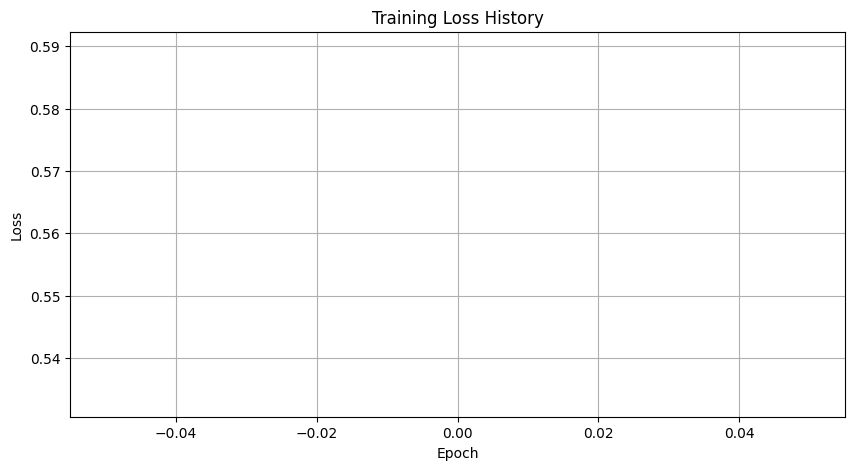

In [5]:
optimizer = Adam(bc.parameters(), lr=0.0001)
loss_func  = NLLLoss()


epochs = 1
#scheduler = CosineAnnealingLR(optimizer, T_max=epochs * len(train_loader), eta_min=1e-6)

loss_history = []
bc.train()



print(f"Starting training on {device}...")
for epoch in range(epochs):
    epoch_bar = tqdm(enumerate(train_loader),
                     desc=f"Epoch {epoch+1}/{epochs}",
                     total=len(train_loader),
                     leave=False)

    total_loss = []
    for bidx, (data, target) in epoch_bar:
        data = data.to(device)
        target = target.to(device)#.flatten().long()

        optimizer.zero_grad(set_to_none=True)

        output = bc(data)
        loss = loss_func(output, target.squeeze())

        total_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        #scheduler.step()

        if bidx % 100 == 0:
            epoch_bar.set_postfix(batch=bidx,
                                  loss=f"{loss.item():.4f}",
                                  lr=f"{optimizer.param_groups[0]['lr']:.6f}")

    avg_loss = sum(total_loss) / len(total_loss)
    loss_history.append(avg_loss)

    print(f"Training [{100.0 * (epoch+1)/epochs:.0f}%] "
          f"Loss: {avg_loss:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title("Training Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [ ]:
print(f"Starting inference on {device}...")
bc.eval()

all_preds, all_targets = [], []

with torch.no_grad():
    for data, target in tqdm(test_loader,
                             desc="Inference",
                             total=len(test_loader),
                             leave=False):
        data, target = data.to(device), target.to(device)#.flatten().long()

        logits = bc(data)

        pred = logits.argmax().view(1)

        all_preds.append(pred.cpu())
        all_targets.append(target.view(-1).cpu())

y_pred = torch.cat(all_preds).numpy().astype(int)
y_true = torch.cat(all_targets).numpy().astype(int)



# 0·6 라벨만 평가
test_mask = (y_true == 0) | (y_true == 6)

print("total samples:", len(y_true))
print("target samples:", test_mask.sum())

# 모델 결과가 1인 것을 6으로 변경
y_pred_mapped = np.where(y_pred == 1, 6, y_pred)

acc = (y_pred_mapped[test_mask] == y_true[test_mask]).mean()
print(f"accuracy (labels 0/6 only): {acc:.4f}")

# 현재 시각을 "YYYYMMDD_HHMMSS" 형식으로 포맷팅
now = datetime.now().strftime("%Y%m%d_%H%M%S")

# 원본 파일명을 기반으로 새 파일명 생성
y_pred_filename = f"y_pred_{now}.csv"

np.savetxt(y_pred_filename, y_pred_mapped, fmt="%d")

Starting inference on cuda...


total samples: 10000
target samples: 2000
accuracy (labels 0/6 only): 0.8070


: 